In [24]:
import numpy as np
import re, csv, nltk
import pandas as pd
pd.options.mode.chained_assignment = None 

less_than = ['harder to','mediocre compared to','flat throw','worse in','worst'
             'bad at','worse than','sssllllloooowwww','heavy','heavier',
             'heaviest','slower','lack','sacrifice','less','lesser',
             'lower','not as','the least','expensive','little fast for','not spinny enough',
             'too ','absorbing a lot of the spin potential','softer','slow']

greater = ['tackier','thinner','thiner','miles ahead','lasts','last longer','lasting','bouncier','good for','good deal of',
           'prefer','appreciate','enough','thicker','firmer','higher throw','ligter','lightest',
           'tacky','extremely fast','hardest','harder',
'easier to','nice','great','fine for looping','medium-high throw','high throw',
'faster','spinnier','spinner','shorter trajectory','speedy','plent speed','spinney','spiny','spinny','speedier',
'spinnier','keeps on spinning','massive spin','monster spin','extreme','fast spins','fast spin','faster',
'better','plenty of','heavy spin','good control','good spin','good speed','cheaper',
'generate tons of spin','fast','insensitive to spin','good grip','grippier','quicker',
'more','better','higher','easier','faster','excellent','light','best','driving']

equal = ['pretty close','fairly close','comparable','similar','equal','same','equivalent',
         'ok speed','same as','so so','as good as','equally',
        'little difference','could cope with','outclasses','very much like','closer to',
         'similiar','not much different','no big difference']

def csv2dict(fn):
    with open(fn) as f:
        reader = csv.reader(f)
        d = list(reader)
    return {k:v for (k,v) in d}

def csv2list(fn):
    with open(fn) as f:
        reader = csv.reader(f)
        d = list(reader)
    return [r[0] for r in d]

# load rubber dictionary
rub_dict = csv2dict('../rubber_dictionary/rub_dict.csv')
regex = re.compile(r'(?<!\w)(' + '|'.join(re.escape(key) for key in rub_dict.keys()) + r')(?!\w)',re.IGNORECASE)
rub_list = csv2list('../rubber_dictionary/rub_name_list.csv')   
#rub_list = sorted(rub_list, reverse=True)

def sub_rubber_names(s,rub_dict=rub_dict,regex=regex):
    if isinstance(s, str):
        return regex.sub(lambda m: rub_dict[m.group(0).lower()],s)
    else:
        return ''

def word_process(s):
    wo = nltk.word_tokenize(s)
    return wo

def find_rubbers(s_words, rub_list=rub_list):
    l = []
    ind = []
    cnt = 0 # at present just "estimate" the character location based on summing up word lengths
    for w in s_words:
        if w in rub_list:
            l.append(w)
            ind.append(cnt)
        cnt = cnt + len(w) + 1        
    return (l,ind)

def assign_comparative(sentences_df,less_than=less_than,greater=greater,equal=equal):
    
    def assign_words(sentences_df,words,category):
            sentences_df.loc[sentences_df['reply_sub'].str.lower().str.contains(words),category] = 1            
        
    assign_words(sentences_df,'spin|rotate','spin')
    assign_words(sentences_df,'fast|speed|slow','speed')
    assign_words(sentences_df,'hard|soft','hardness')
    assign_words(sentences_df,'tack|grip|sticky','tackiness') #stiff not useful- usually stiff blades
    assign_words(sentences_df,'control','control')
    assign_words(sentences_df,'bounc|lively','bounce')
    assign_words(sentences_df,'arc|angle|throw|flat|high arc|high throw','throw')
    assign_words(sentences_df,'durable|last long|long last','durability')
    assign_words(sentences_df,'for block','blocking')
    assign_words(sentences_df,'for loop|driv','looping')
    sentences_df.loc[sentences_df['reply_sub'].str.lower().str.contains\
                     ('Spin Spiel Ultima|backspin|T88 Ultra Spin|geospin|spinmax|topspin|underspin|\-spin')\
                     ,'spin'] = 0
    sentences_df.loc[sentences_df['reply_sub'].str.lower().str.contains('\-soft|\-hard'),'hardness'] = 0
    sentences_df.loc[sentences_df['reply_sub'].str.lower().str.contains('throw it|throw away'),'throw'] = 0
    sentences_df.loc[sentences_df['reply_sub'].str.lower().str.contains('speed glue|Rapid Speed'),'speed'] = 0
    sentences_df = sentences_df.fillna(0)
    
    
    # this part is for getting multiple word labels
    sentences_df['comparative_word_begin_idx'] = [[]] * sentences_df.shape[0]
    sentences_df['comparative'] = [[]] * sentences_df.shape[0]

    for idx,sentence in sentences_df.reply_split.items():
        sentence = sentence.lower()
        loc_list = []
        sentiment_list = []
        word_list = []
        for lesser_word in less_than:
            location = sentence.find(lesser_word)
            if location != -1 and location not in loc_list:
                loc_list.append(location)
                sentiment_list.append('less')
                word_list.append(lesser_word)
        for greater_word in greater:
            location = sentence.find(greater_word)
            if location != -1 and location not in loc_list:
                loc_list.append(location)
                sentiment_list.append('better')
                word_list.append(greater_word)
        for equal_word in equal:
            location = sentence.find(equal_word)
            if location != -1 and location not in loc_list:
                loc_list.append(location)
                sentiment_list.append('equal')
                word_list.append(equal_word)
        sentences_df.at[idx,'comparative_word_begin_idx'] = loc_list
        sentences_df.at[idx,'comparative'] = sentiment_list
        sentences_df.at[idx,'comparative_words'] = word_list
    
    # this is good for having only one aspect in the sentence
    sentences_df['comparative_word_begin_idx_first'] = -1000
    
    for idx,sentence in sentences_df.reply_split.items():
        sentence = sentence.lower()
        for lesser_word in less_than:
            location = sentence.find(lesser_word)
            if location != -1:
                sentences_df.loc[idx,'comparative_word_begin_idx_first'] = location
                sentences_df.loc[idx,'comparative_first'] = 'less'
                sentences_df.loc[idx,'comparative_word'] = lesser_word
        if sentences_df.loc[idx,'comparative_word_begin_idx_first']== -1000:
            for greater_word in greater:
                location = sentence.find(greater_word)
                if location != -1:
                    sentences_df.loc[idx,'comparative_word_begin_idx_first'] = location
                    sentences_df.loc[idx,'comparative_first'] = 'better'
                    sentences_df.loc[idx,'comparative_word'] = greater_word
        if sentences_df.loc[idx,'comparative_word_begin_idx_first'] == -1000:
            for equal_word in equal:
                location = sentence.find(equal_word)
                if location != -1:
                    sentences_df.loc[idx,'comparative_word_begin_idx_first'] = location
                    sentences_df.loc[idx,'comparative_first'] = 'equal'
                    sentences_df.loc[idx,'comparative_word'] = equal_word
                    
    sentences_df['specific_aspects_cnt'] = sentences_df['spin']+sentences_df['speed']+\
                                        sentences_df['hardness']+sentences_df['tackiness']+\
                                        sentences_df['control']+sentences_df['bounce']+\
                                        sentences_df['throw']+sentences_df['durability']+\
                                        sentences_df['blocking']+sentences_df['looping']

    sentences_df.loc[(sentences_df['specific_aspects_cnt']!=1)&\
                     (sentences_df['comparative_first'].isna()==False),'overall'] = 1

    sentences_df['overall'] = sentences_df['overall'].fillna(0)

    sentences_df['all_aspects_cnt'] = sentences_df['specific_aspects_cnt'] + sentences_df['overall']
    
    all_labeled = sentences_df # [(sentences_df['comparative_word_begin_idx_first']!=-1000)]
    
    return all_labeled


def do_the_thing(fn):
       
    df_raw = pd.read_csv(fn,index_col=0)
    df_raw.drop(df_raw.columns[df_raw.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
    df_raw.dropna()    
    # select out only comparative and descriptive comments
    df = df_raw[(df_raw['classification']=='comparative') | (df_raw['classification']=='descriptive')]     
    
    # filter out sentences with question mark
    df = df[~df['reply_split'].str.lower().str.contains('?',regex=False)]
    
    # substitute rubber names, identify relevant rubbers
    # at present, just identify those in the rubber dictionary
    df.loc[:,'reply_sub'] = df['reply_split'].apply(sub_rubber_names)
    df.loc[:,'reply_words'] = df['reply_sub'].apply(word_process)
    df[['entity','entity_locs']] = df['reply_words'].apply(find_rubbers).apply(pd.Series)

    df = assign_comparative(df)
    
    return df, df_raw


In [25]:
df, df_raw = do_the_thing('../Comparison/Final_eval_2.csv')

df_comp = df[df['classification']=='comparative']
df_desc = df[df['classification']=='descriptive']

In [26]:
df.head()

,id,thread_title,reply_split,classification,reply_sub,reply_words,entity,entity_locs,spin,speed,...,looping,comparative_word_begin_idx,comparative,comparative_words,comparative_word_begin_idx_first,comparative_first,comparative_word,specific_aspects_cnt,overall,all_aspects_cnt
8,5f6c219629a893d240caed63,chop vs spin rubber -- which characteristics d...,"More bounce, more speed.",descriptive,"More bounce, more speed.","[More, bounce, ,, more, speed, .]",[],[],0.0,1.0,...,0.0,[0],[better],more,0,better,more,2.0,1.0,3.0
52,5f6c21e7035f29fdaf67ffa8,dignics 09c vs dignics 05 review,"The Dignics plays better than the silver, thou...",comparative,The Butterfly-Dignics plays better than the si...,"[The, Butterfly-Dignics, plays, better, than, ...",[Butterfly-Dignics],[4],0.0,0.0,...,0.0,[18],[better],[better],18,better,better,0.0,1.0,1.0
61,5f6c21e7035f29fdaf67ffa8,dignics 09c vs dignics 05 review,"Teessport are reliable,I've had loads of stuff...",descriptive,"Teessport are reliable,I've had loads of stuff...","[Teessport, are, reliable, ,, I, 've, had, loa...",[],[],0.0,0.0,...,0.0,[],[],[],-1000,NaN,NaN,0.0,0.0,0.0
70,5f6c21e8035f29fdaf67ffa9,DHS Hurricane 3 Neo 2.15 vs. 2.2,"Ordinary H3 turned out to be too slow for me, ...",comparative,Ordinary DHS-Hurricane-3 turned out to be too ...,"[Ordinary, DHS-Hurricane-3, turned, out, to, b...","[DHS-Hurricane-3, DHS-NEO-Hurricane-3, Chinese...","[9, 134, 178]",0.0,1.0,...,0.0,"[29, 33, 137]","[less, less, better]","[too , slow, faster]",33,less,slow,1.0,0.0,1.0
81,5f6c21e8035f29fdaf67ffa9,DHS Hurricane 3 Neo 2.15 vs. 2.2,The 2.15 felt easier for me to use on my Bh.,descriptive,The 2.15 felt easier for me to use on my Bh.,"[The, 2.15, felt, easier, for, me, to, use, on...",[],[],0.0,0.0,...,0.0,[14],[better],[easier],14,better,easier,0.0,1.0,1.0


In [32]:
def print_row_info(row):
    print(row.reply_split)
    print('    aspects: {0}'.format([s for s in col_names[row[col_names]!=0]]))
    print('    rubbers: {0}'.format(row.entity))
    #print('    comparative relation: {0}'.format(row.comparative))     
    #print('    comparative words: {0}'.format(row.comparative_words))
    print('    comparative relation: {0}'.format(row.comparative_first))     
    print('    comparative word: {0}'.format(row.comparative_word))
    print('    comparative word begin idx: {0}'.format(row.comparative_word_begin_idx_first))
    print('====================')
    #print(row.entity_locs)

col_names = df.columns[8:18]
for ind, row in df_comp.iterrows():
    if row['specific_aspects_cnt']==1:
        if len(set(row.entity)) <= 2:
            if 'better' in row.comparative:
                print_row_info(row)


The 401 is a tiny bit more lively than the usual chinese suspects (at least that is my impression), altough it is nowhere near being springy as the usual tensors.
    aspects: ['bounce']
    rubbers: ['Tensor-rubbers']
    comparative relation: better
    comparative word: more
    comparative word begin idx: 22
401 is just abit slower than Vega China, but still faster then any china rubbers I've played with.
    aspects: ['speed']
    rubbers: []
    comparative relation: less
    comparative word: slow
    comparative word begin idx: 17
I can nicely switch between brush looping for high spin balls and more direct hitting at loops for more power.Compared to springy ESN rubbers, you always have to perform a proper stroke at loops.
    aspects: ['spin']
    rubbers: ['ESN-rubbers']
    comparative relation: better
    comparative word: more
    comparative word begin idx: 66
In addition I tried* the Vega Japan, very good rubber but not as spinny as the other ones (=> less direct point u

    comparative relation: better
    comparative word: more
    comparative word begin idx: 66
The sponge is harder (not super hard but harder than Calibra Sound) and I think (I'm not 100% sure) the top sheet is thicker.
    aspects: ['hardness']
    rubbers: []
    comparative relation: better
    comparative word: harder
    comparative word begin idx: 14
Rasant has better spin than Calibra Sound.
    aspects: ['spin']
    rubbers: ['Andro-Rasant']
    comparative relation: better
    comparative word: better
    comparative word begin idx: 11
Pushing is not as spiny (as with the TG2)I dislike the TG3 on all my blades except on my Hallmark(tried it on KC, Tube Carbo and Iolite) I don't recommend this one to be used without EEII, or speed glue.
    aspects: ['spin']
    rubbers: ['Stiga-Carbo']
    comparative relation: less
    comparative word: not as
    comparative word begin idx: 11
Though the orange sponged TG3 is way harder than the cream sponged one(tg3)Both TG2&3 are begging 

    comparative word begin idx: 19
The nanaocannon is much faster than the 999 EU
    aspects: ['speed']
    rubbers: []
    comparative relation: better
    comparative word: faster
    comparative word begin idx: 24
Elite is spinnier than Nano Cannon.
    aspects: ['spin']
    rubbers: []
    comparative relation: better
    comparative word: spinnier
    comparative word begin idx: 9
Nano is much faster than Elite.
    aspects: ['speed']
    rubbers: []
    comparative relation: better
    comparative word: faster
    comparative word begin idx: 13
Elite is higher throw than Nano.
    aspects: ['throw']
    rubbers: []
    comparative relation: better
    comparative word: higher
    comparative word begin idx: 9
Maybe not as fast as my Tenergy but still fast...
    aspects: ['speed']
    rubbers: ['Butterfly-Tenergy']
    comparative relation: less
    comparative word: not as
    comparative word begin idx: 6
I agree that Optimum MP is faster.
    aspects: ['speed']
    rubbers: [

this iscompletely different when it comes to the likes of the hurricane rubbers or most others, also the rubber isnt that strong either.now on a different note it plays quite beautifully, the speed is way greater than H3 rubbers, or even H3 prov.
    aspects: ['speed']
    rubbers: ['DHS-Hurricane', 'DHS-Hurricane-3', 'DHS-Hurricane-3']
    comparative relation: better
    comparative word: great
    comparative word begin idx: 205
The rubber was sensibly harder than tenergy, though softer than Hurricane 3.
    aspects: ['hardness']
    rubbers: ['Butterfly-Tenergy', 'DHS-Hurricane-3']
    comparative relation: less
    comparative word: softer
    comparative word begin idx: 52
The spin seemed to be good, like tenergy (which by the way I find less spinny than Hurricane 3 or Globe 999, but I am going off topic).
    aspects: ['spin']
    rubbers: ['Butterfly-Tenergy', 'DHS-Hurricane-3']
    comparative relation: less
    comparative word: less
    comparative word begin idx: 66
speed d

    comparative relation: better
    comparative word: faster
    comparative word begin idx: 36
Zeta is pretty fast fels faster then Omega2 to me as well touch faster then roxon 450.
    aspects: ['speed']
    rubbers: ['Andro-Roxon-450']
    comparative relation: better
    comparative word: faster
    comparative word begin idx: 25
In case of Boost TC and Zeta A if TC is more durable then TC is the real winer as guys said that was an a only slight difference bettwen the two rubbers.
    aspects: ['durability']
    rubbers: ['Stiga-Boost-TC']
    comparative relation: better
    comparative word: light
    comparative word begin idx: 112
It also threw a lot higher than Bryce Speed did.
    aspects: ['speed']
    rubbers: ['Butterfly-Bryce-Speed']
    comparative relation: better
    comparative word: higher
    comparative word begin idx: 20
OMP has a much grippier topsheet and is better for serving but neither is great.
    aspects: ['tackiness']
    rubbers: []
    comparative rela

In [28]:
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

def accum_col(df):
    p = []
    df.apply(lambda l: p.extend(set(l)))
    return p

def plot_most_bar(p,num):
    most = Counter(p).most_common()

    x, y = [], []
    for word,count in most[:num]:
        x.append(word)
        y.append(count)

    plt.figure(figsize=(15,3*num/10.0))
    ax = sns.barplot(x=y,y=x)    
    

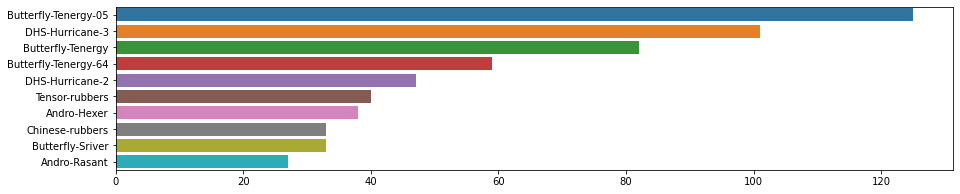

In [29]:
plot_most_bar(accum_col(df_comp['entity']),10)